# Create a simple NN without training

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Assume the model parameters have already been optimised by back propagation
class BasicNN(nn.Module):

    def __init__(self):
        
        super().__init__()

        # Initialise the weights and biases. By turning them into parameters of the neural network, it gives me an option to optimise it
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.0), requires_grad=False)

    # Connect the input, activation functions to the output via the weights and biases
    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [9]:
# test if the model works
# Create input values
input_doses = torch.linspace(0, 1, steps=11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [10]:
# Initialise the model
model = BasicNN()

# Feed the input to the model
output_values = model(input_doses)

Text(0.5, 0, 'Dose')

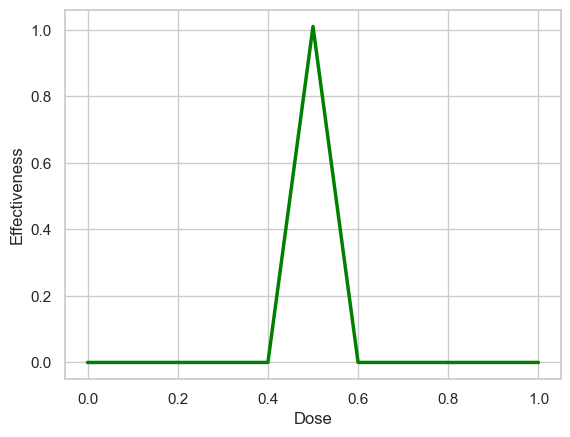

In [11]:
# Plot graph with seaborn and matplotlib
# set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             y=output_values,
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

# Train one particular parameter - final_bias

In [12]:
# Rename the class to BasicNN_train
class BasicNN_train(nn.Module):

    def __init__(self):
        
        super().__init__()

        # Initialise the weights and biases. By turning them into parameters of the neural network, it gives me an option to optimise it
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        # Setting a bias to 0.0 is just a convention and placeholder here
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    # Connect the input, activation functions to the output via the weights and biases
    def forward(self, input):

        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu =  scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias
        output = F.relu(input_to_final_relu)

        return output

In [13]:
# See the impact to the model performance with an unoptimized parameter
model = BasicNN_train()

# Feed the input to the model
output_values = model(input_doses)

Text(0.5, 0, 'Dose')

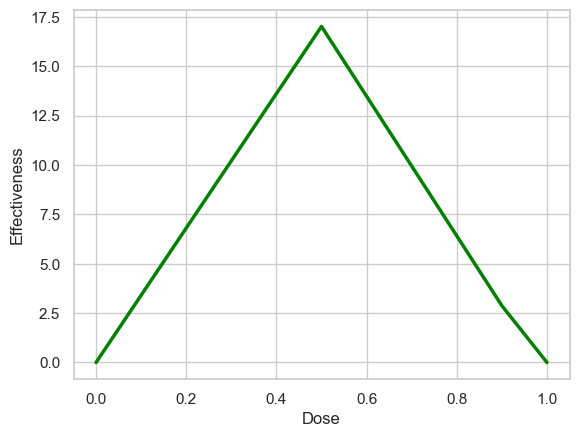

In [16]:
# Plot graph with seaborn and matplotlib
# set up the style of seaborn
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             # need to detach the output as seaborn doesn't what to do with the gradient
             y=output_values.detach(),
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")

We need to optimize final_bias as the effectiveness is out of range (17)

In [29]:
# Create training data
# features
inputs = torch.tensor([0. ,0.5, 1.])

# labels
labels = torch.tensor([0., 1., 0.])

In [31]:
# Optimise final_bias
# configure the optimizer
# Will optimize all the model parameters with which require_grad is set to True
optimizer = SGD(model.parameters(), lr=0.1)

# Need to convert model.final_bias.data, which is a tensor, into a string. Remark: model.final_bias itself is of type nn.Parameter
print("Final bias, before optimization: ", str(model.final_bias.data), "\n")

# Create the training loop
# Outer loop - loop through every epoch
for epoch in range(100):

    # Keep track of the total loss in each epoch (for educational purpose only, normally we should loop the batches in each epoch)
    total_loss = 0

    # Inner loop - loop through every data point in each epoch
    for iteration in range(len(inputs)):

        input_i = inputs[iteration]
        label_i = labels[iteration]

        # Forward pass
        output_i = model(input_i)
        # Calculate the squared residual
        loss = (output_i - label_i)**2
        # Calculate the derivative of the loss function with respect to final_bias (the parameter to be optimized)
        loss.backward()

        total_loss += float(loss)

    # Stopping criteria
    if (total_loss < 0.0001):
        print("Number of epochs: " + str(epoch), "\n")
        break

    # If the stopping criteria is not met, take a step towards the optimal value with the calculated gradients
    # optimizer can access to the accumlative derivatives stored in the model during each epoch
    optimizer.step()
    # Remove the previous accumulated gradient
    optimizer.zero_grad()
    
    print("Step: " + str(epoch) + " Final Bias: " + str(model.final_bias.data) + "\n")
    

Final bias, before optimization:  tensor(0.) 

Step: 0 Final Bias: tensor(-3.2020)

Step: 1 Final Bias: tensor(-5.7636)

Step: 2 Final Bias: tensor(-7.8129)

Step: 3 Final Bias: tensor(-9.4523)

Step: 4 Final Bias: tensor(-10.7638)

Step: 5 Final Bias: tensor(-11.8131)

Step: 6 Final Bias: tensor(-12.6525)

Step: 7 Final Bias: tensor(-13.3240)

Step: 8 Final Bias: tensor(-13.8612)

Step: 9 Final Bias: tensor(-14.2909)

Step: 10 Final Bias: tensor(-14.6348)

Step: 11 Final Bias: tensor(-14.9098)

Step: 12 Final Bias: tensor(-15.1298)

Step: 13 Final Bias: tensor(-15.3059)

Step: 14 Final Bias: tensor(-15.4467)

Step: 15 Final Bias: tensor(-15.5594)

Step: 16 Final Bias: tensor(-15.6495)

Step: 17 Final Bias: tensor(-15.7216)

Step: 18 Final Bias: tensor(-15.7793)

Step: 19 Final Bias: tensor(-15.8254)

Step: 20 Final Bias: tensor(-15.8623)

Step: 21 Final Bias: tensor(-15.8919)

Step: 22 Final Bias: tensor(-15.9155)

Step: 23 Final Bias: tensor(-15.9344)

Step: 24 Final Bias: tensor(-15

Text(0.5, 0, 'Dose')

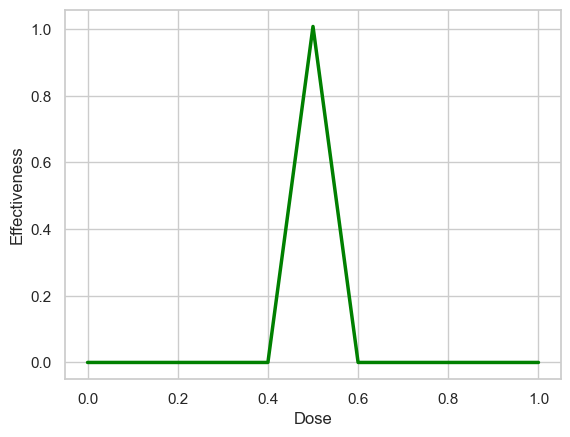

In [32]:
# Plot the graph again to see if the parameter is fully optimized
# Don't need to create a model anymore, it is created up there
output_values = model(input_doses)

sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses,
             # need to detach the output as seaborn doesn't what to do with the gradient
             y=output_values.detach(),
             color="green",
             linewidth=2.5)

plt.ylabel("Effectiveness")
plt.xlabel("Dose")